In [1]:
import pandas as pd
import numpy as np
import spacy
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

In [234]:
df = pd.read_csv("data/recipe_data.csv")

In [235]:
df.drop(columns=["url", "image"], axis=1, inplace=True)

## 1. Dataset Check

In [236]:
df.head()

,name,ingredients,directions,raw_ingredients,meta_Total Time,meta_Servings,nutrition_Calories,nutrition_Fat,nutrition_Carbs,nutrition_Protein,images
0,Pumpkin Apple Streusel Muffins,2 ½ cups all-purpose flour; 2 cups white sugar...,1. Preheat oven to 350 degrees F (175 degrees ...,all-purpose flour; white sugar; pumpkin pie sp...,1 hr,18,249.0,8g,43g,3g,['https://www.allrecipes.com/thmb/pE6zNfkwI0xo...
1,Pumpkin Banana Oat Muffins,1 cup all-purpose flour; 1 cup oat flour; 1 te...,1. Preheat the oven to 350 degrees F (175 degr...,all-purpose flour; oat flour; baking soda; bak...,50 mins,12,427.0,24g,51g,7g,['https://www.allrecipes.com/thmb/WkOjZNa-oOTv...
2,Pumpkin Chip Muffins,4 eggs; 2 cups white sugar; 1 (15 ounce) can ...,1. Preheat oven to 400 degrees F (200 degrees ...,eggs; white sugar; pumpkin; vegetable oil; all...,30 mins,24,327.0,19g,39g,4g,['https://www.allrecipes.com/thmb/wKR4DlEL4CiO...
3,Apple Cake with Caramel Glaze,2 cups white sugar; 1 ½ cups vegetable oil; 2 ...,1. Gather all ingredients. Preheat the oven to...,white sugar; vegetable oil; vanilla extract; e...,1 hr 50 mins,12,682.0,43g,71g,7g,['https://www.allrecipes.com/thmb/Qwe0KockE1yl...
4,Umami Mushroom Broth,12 cups water; 3 pounds earthy mushrooms; 2 la...,"1. Combine water, mushrooms, onions, celery, c...","earthy mushrooms; onions, roughly chopped; cel...",55 mins,5,110.0,1g,20g,10g,['https://www.allrecipes.com/thmb/QhcDy9uuf4pv...


In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48576 entries, 0 to 48575
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                48576 non-null  object 
 1   ingredients         48576 non-null  object 
 2   directions          48576 non-null  object 
 3   raw_ingredients     48575 non-null  object 
 4   meta_Total Time     46696 non-null  object 
 5   meta_Servings       48563 non-null  object 
 6   nutrition_Calories  47895 non-null  float64
 7   nutrition_Fat       47143 non-null  object 
 8   nutrition_Carbs     47835 non-null  object 
 9   nutrition_Protein   47559 non-null  object 
 10  images              48576 non-null  object 
dtypes: float64(1), object(10)
memory usage: 4.1+ MB


In [238]:
df.isna().sum()

name                     0
ingredients              0
directions               0
raw_ingredients          1
meta_Total Time       1880
meta_Servings           13
nutrition_Calories     681
nutrition_Fat         1433
nutrition_Carbs        741
nutrition_Protein     1017
images                   0
dtype: int64

Only relevant columns for this project would be the name, directions, and the ingredients. These columns are all filled. When creating the final application, the actual NAN values in these columns would have to just be replaced with a string like "N/A"

In [239]:
df = df.drop_duplicates(subset=["name"])

In [240]:
df.nunique()

name                  48532
ingredients           48523
directions            48525
raw_ingredients       48483
meta_Total Time         734
meta_Servings           104
nutrition_Calories     1295
nutrition_Fat           155
nutrition_Carbs         222
nutrition_Protein       133
images                48532
dtype: int64

In [241]:
df.shape

(48532, 11)

In [242]:
names = df["name"].unique()
ingredients = df["ingredients"].unique()
directions = df["directions"].unique()

print(names)
print(ingredients)
print(directions)

['Pumpkin Apple Streusel Muffins' 'Pumpkin Banana Oat Muffins'
 'Pumpkin Chip Muffins' ... 'Spicy Salmon Marinade'
 'Easy Shrimp Chow Mein' 'Garlic-Smashed Potatoes']
['2 ½ cups all-purpose flour; 2 cups white sugar; 1 tablespoon pumpkin pie spice; 1 teaspoon baking soda; ½ teaspoon salt; 1 cup canned pumpkin puree; ½ cup vegetable oil; 2  eggs, lightly beaten; 2 cups peeled, cored and chopped apple; 2 tablespoons all-purpose flour; ¼ cup white sugar; ½ teaspoon ground cinnamon; 4 teaspoons butter; 2 ½ cups all-purpose flour; 2 cups white sugar; 1 tablespoon pumpkin pie spice; 1 teaspoon baking soda; ½ teaspoon salt; 1 cup canned pumpkin puree; ½ cup vegetable oil; 2  eggs, lightly beaten; 2 cups peeled, cored and chopped apple; 2 tablespoons all-purpose flour; ¼ cup white sugar; ½ teaspoon ground cinnamon; 4 teaspoons butter'
 '1 cup all-purpose flour; 1 cup oat flour; 1 teaspoon baking soda; 1 teaspoon baking powder; 1 teaspoon salt; 1 teaspoon cinnamon; 1 teaspoon ground ginger; 1 t

## 2. Data Transformation

### 2.1 Initial Cleaning and Topic Modeling

In [243]:
recipe_names = df["name"]

In [245]:
recipe_names = recipe_names.str.lower()

In [246]:
recipe_names = recipe_names.apply(lambda x: re.sub(r'\w*\d\w*', '', x))

In [247]:
recipe_names = recipe_names.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [248]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [249]:
recipe_names = recipe_names.apply(lambda x: " ".join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [250]:
filter_words = [
    # Time / speed descriptors
    'quick', 'easy', 'fast', 'simple', 'ready', 'instant', 'one-pot', 'minute', 'hour', 'second',
    
    # Diet / health labels
    'vegan', 'vegetarian', 'low-carb', 'gluten-free', 'keto', 'paleo', 'sugar-free', 'kosher', 'halal',
    
    # Size / serving descriptors
    'mini', 'small', 'large', 'family-size', 'single', 'portion', 'individual', 'filling', 'big',
    
    # Occasion / meal type
    'breakfast', 'lunch', 'dinner', 'snack', 'dessert', 'holiday', 'party', 'brunch',
    
    # Generic words
    'recipe', 'homemade', 'classic', 'authentic', 'easy-to-make', 'best', 'tasty', 'fresh'
    
    # Brands or people (common in scraped datasets)
    'grandma', 'chef',
]

In [251]:
def remove_filler_words(text):
    tokens = text.lower().split()
    return " ".join(t for t in tokens if t not in filter_words)

recipe_names = recipe_names.apply(remove_filler_words)

In [252]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    min_df=10,
    max_df=0.8,
    ngram_range=(1,2),
    max_features=20000
)

X = vectorizer.fit_transform(recipe_names)

In [253]:
n_topics = 100

nmf = NMF(
    n_components=n_topics,
    random_state=42,
    init="nndsvda",
    max_iter=500
)

W = nmf.fit_transform(X)
H = nmf.components_

In [254]:
feature_names = vectorizer.get_feature_names_out()

In [255]:
def get_topic_words(H, topic_id, feature_names, top_n=8):
    topic = H[topic_id]              # topic must be numeric array
    topic = topic.astype(float)      # ensure it's numeric
    top_indices = topic.argsort()[-top_n:][::-1]
    return [feature_names[i] for i in top_indices]

In [256]:
get_topic_words(H, 0, feature_names)

['chicken',
 'chicken salad',
 'chicken breast',
 'breast',
 'chicken thigh',
 'thigh',
 'chicken wing',
 'bake chicken']

In [301]:
output_df = pd.DataFrame(recipe_names)

In [276]:
W.shape[0] == len(recipe_names)

True

In [259]:
topics = pd.Series(W.argmax(axis=1), index=output_df.index, name="topics")
topic_strengths = pd.Series(W.max(axis=1), index = output_df.index, name="topic_strengths")

In [302]:
output_df["topics"] = topics
output_df["topic_strengths"] = topic_strengths

In [303]:
output_df.head()

,name,topics,topic_strengths
0,pumpkin apple streusel muffin,26,0.098276
1,pumpkin banana oat muffin,26,0.065610
2,pumpkin chip muffin,26,0.092725
3,apple cake caramel glaze,23,0.079807
4,umami mushroom broth,43,0.090070


In [262]:
X_embedded = PCA(n_components=30, random_state=42).fit_transform(W)


In [263]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42
).fit_transform(X_embedded)

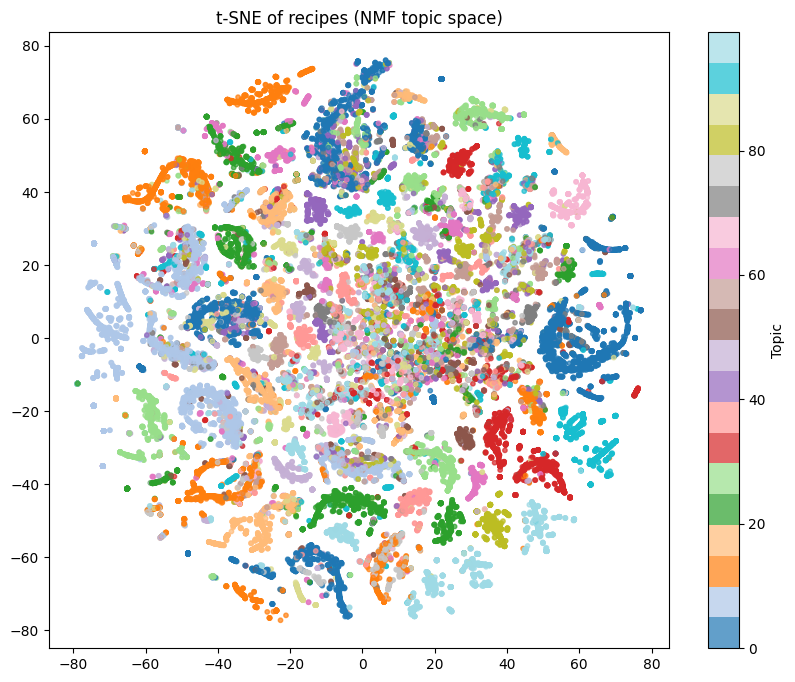

In [264]:
plt.figure(figsize=(10, 8))
plt.scatter(
    tsne[:, 0],
    tsne[:, 1],
    c=output_df["topics"],
    cmap="tab20",
    s=10,
    alpha=0.7
)
plt.colorbar(label="Topic")
plt.title("t-SNE of recipes (NMF topic space)")
plt.show()

#### Results:

t-SNE plot shows that many topics are scattered and need to be merged.

### 2.2 Merging Similar Topics

In [265]:
topic_sim = cosine_similarity(H)


In [266]:
topic_dist = 1 - topic_sim

condensed = squareform(topic_dist, checks=False)

Z = linkage(condensed, method="average")

meta_labels = fcluster(Z, t=90, criterion="maxclust")

In [267]:
meta_labels

array([18, 74,  1, 78,  5, 63, 31, 49, 38, 81, 32, 11, 75, 86,  2, 53, 33,
       20, 66,  3, 41,  6, 90, 64, 29, 48, 65, 19,  1, 27, 10, 69, 23, 21,
       59, 35, 24, 67, 62, 72, 17,  4, 13, 26, 56, 89, 25, 70, 28, 50, 14,
       85, 15, 51, 11, 45, 71, 43,  7, 36, 82, 88, 30, 42, 57, 12, 47, 77,
        9, 68, 60, 46, 52, 22, 83,  2, 80, 61, 84,  1, 39, 37, 55, 12, 58,
       44, 79,  8, 87, 73, 35,  8, 75, 45, 40, 16, 60, 76, 54, 34],
      dtype=int32)

In [304]:
output_df["meta_topic"] = output_df["topics"].map(
    {i: meta_labels[i] for i in range(len(meta_labels))}
)


In [305]:
output_df.head()

,name,topics,topic_strengths,meta_topic
0,pumpkin apple streusel muffin,26,0.098276,65
1,pumpkin banana oat muffin,26,0.065610,65
2,pumpkin chip muffin,26,0.092725,65
3,apple cake caramel glaze,23,0.079807,64
4,umami mushroom broth,43,0.090070,26


In [270]:
def describe_meta_topic(meta_id, H, meta_labels, vocab, top_k=10):
    topic_ids = np.where(meta_labels == meta_id)[0]
    weights = H[topic_ids].mean(axis=0)
    top_terms = np.argsort(weights)[-top_k:][::-1]
    return [vocab[i] for i in top_terms]

In [271]:
for meta_id in range(meta_labels.max() + 1):
    terms = describe_meta_topic(
        meta_id=meta_id,
        H=H,
        meta_labels=meta_labels,
        vocab=feature_names,
        top_k=10
    )
    print(f"\nMeta-topic {meta_id}")
    print(", ".join(terms))


Meta-topic 0
zuppa toscana, cucumber tomato, dream, doughnut, dough, double chocolate, double, donut, dollar, dog treat

Meta-topic 1
potato, sweet, sour, sweet potato, sour cream, sweet sour, potato salad, mashed, potato soup, mashed potato

Meta-topic 2
ice, cream, ice cream, cream cheese, cream pie, tea, cream sauce, pop, sour cream, ice pop

Meta-topic 3
cheese, cream cheese, mac, mac cheese, macaroni, blue, blue cheese, macaroni cheese, ball, cheese ball

Meta-topic 4
spicy, sweet spicy, spicy chicken, spicy shrimp, eggplant, spicy sausage, korean, pickle, spicy bake, spicy beef

Meta-topic 5
salad, chicken salad, potato salad, pasta salad, cucumber, dress, salad dress, cucumber salad, bean salad, tuna

Meta-topic 6
pasta, pasta salad, chicken pasta, pasta sauce, pasta bake, shrimp pasta, primavera, pesto, asparagus, pasta primavera

Meta-topic 7
creamy, creamy chicken, creamy mushroom, dress, dressing, mashed, fudge, coleslaw, creamy potato, mashed potato

Meta-topic 8
pineapple

/var/folders/2b/zvv8556n7vbfkz5g_xhjv4mc0000gn/T/ipykernel_4354/881143806.py:3: RuntimeWarning: Mean of empty slice
  weights = H[topic_ids].mean(axis=0)
/Users/christopherli/ML/RecipeImageClassifier/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [272]:
score = silhouette_score(W, output_df["meta_topic"], metric="cosine")
print(score)

0.47602584732399633


#### Results:

Meta labels are separated relatively well with an acceptable silhouette score.

In [306]:
data_transformed = pd.DataFrame()

In [307]:
data_transformed["original_name"] = df["name"]
data_transformed["recipe"] = df["directions"]

In [311]:
output_df["lemmatized_name"] = output_df["name"]
output_df.drop(["name", "topics", "topic_strengths"], inplace=True, axis=1)

In [312]:
data_transformed = pd.concat([data_transformed, output_df], axis=1)

In [313]:
data_transformed.head()

,original_name,recipe,meta_topic,lemmatized_name
0,Pumpkin Apple Streusel Muffins,1. Preheat oven to 350 degrees F (175 degrees ...,65,pumpkin apple streusel muffin
1,Pumpkin Banana Oat Muffins,1. Preheat the oven to 350 degrees F (175 degr...,65,pumpkin banana oat muffin
2,Pumpkin Chip Muffins,1. Preheat oven to 400 degrees F (200 degrees ...,65,pumpkin chip muffin
3,Apple Cake with Caramel Glaze,1. Gather all ingredients. Preheat the oven to...,64,apple cake caramel glaze
4,Umami Mushroom Broth,"1. Combine water, mushrooms, onions, celery, c...",26,umami mushroom broth


In [314]:
data_transformed.to_csv("data/recipe_meta_topics.csv")